<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_data_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
import os

# Specify the directory path
#directory_path = '//Users/mirthedankloff/Documents/XAI_Bias_Error/COMPAS'

# Traverse the directory and print the names of all files
#for dirname, _, filenames in os.walk(directory_path):
   # for filename in filenames:
    #    print(os.path.join(dirname, filename))


# Load cleaned Compas data

In [2]:
#compas_s = pd.read_csv("/content/final_preprocessed_compas(2).csv")
#ofercompas = pd.read_csv("/content/propublica_data_for_fairml.csv")
#originalcompas = pd.read_csv("/content/compas-scores-two-years-violent.csv")
#cox_violent_filt = pd.read_csv('/content/cox-violent-parsed_filt.csv')
compas_2 = pd.read_csv('/content/cleaned_compas_data.csv')

In [3]:
compas_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       7214 non-null   int64 
 1   sex                      7214 non-null   object
 2   age                      7214 non-null   int64 
 3   age_cat                  7214 non-null   object
 4   race                     7214 non-null   object
 5   decile_score             7214 non-null   int64 
 6   priors_count             7214 non-null   int64 
 7   is_recid                 7214 non-null   int64 
 8   is_violent_recid         7214 non-null   int64 
 9   score_text               7214 non-null   object
 10  v_decile_score           7214 non-null   int64 
 11  priors_count.1           7214 non-null   int64 
 12  event                    7214 non-null   int64 
 13  two_year_recid           7214 non-null   int64 
 14  sex_Female               7214 non-null  

In [4]:
#Check if is_recid and two year recid are the same
if (compas_2['is_recid'] == compas_2['two_year_recid']).any():
    print("same")
else:
    print("not same")

same


In [5]:
#Select Features
X = compas_2.drop(['two_year_recid', 'id', 'score_text', 'v_decile_score', 'priors_count.1', 'is_recid', 'is_violent_recid', 'sex',
                   'age_cat', 'race', 'event', 'age_cat_Greater than 45', 'age_cat_25 - 45', 'age_cat_Less than 25', 'decile_score'],axis=1)
Y = compas_2['two_year_recid']

Y.shape[0]
X.shape[0]


7214

# Train Random Forest Classifier

In [6]:
#Train model

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    #test_size = 0.3,
                                                    test_size = 0.7, shuffle = True, stratify = Y)

model = RandomForestClassifier()
model.fit(X_train, Y_train)

#predictions
Yhat = model.predict(X_test)
len(Yhat)


5050

# Collect the errors

In [7]:
#Create data frame to contain the predicted and true classes - converting y_hat np to df
predictions = pd.DataFrame()
predictions['predicted_class'] = Yhat.tolist()
predictions = predictions.set_index(X_test.index)
predictions['true_class'] = Y_test

#calculating the errors with the absolute value
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

#adding predictions to the test data
entire_dataset = X_test.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = entire_dataset['errors']
df_out = entire_dataset.drop(['predicted_class', 'true_class', 'errors'], axis=1)
entire_dataset[entire_dataset['errors']==1]

#accuracy
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

#confusion matrix
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)


Accuracy: 0.6168
[[1802  972]
 [ 963 1313]]


# Selecting 4 labels (FP, FN, TP, TN)

In [8]:
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
entire_dataset = entire_dataset.apply(get_error_type, axis=1)

print(entire_dataset)

      age  priors_count  sex_Female  sex_Male  race_African-American  \
511    26             0           1         0                      1   
5138   30             1           0         1                      0   
7050   52             0           1         0                      0   
3364   38             1           0         1                      1   
3462   44             7           0         1                      1   
...   ...           ...         ...       ...                    ...   
3243   56            10           0         1                      0   
6747   23             1           0         1                      0   
5776   21             2           0         1                      1   
656    47            20           0         1                      1   
3004   37             3           0         1                      0   

      race_Asian  race_Caucasian  race_Hispanic  race_Native American  \
511            0               0              0               

In [9]:
#Check if there are any FP/FN
if (entire_dataset['FP'] == 1).any():
    print("There's at least one occurrence of 1 in the column.")
else:
    print("There's no occurrence of 1 in the column.")



for col in entire_dataset:
  print (col)

There's at least one occurrence of 1 in the column.
age
priors_count
sex_Female
sex_Male
race_African-American
race_Asian
race_Caucasian
race_Hispanic
race_Native American
race_Other
predicted_class
true_class
errors
TP
TN
FN
FP


# add categorical for error type to make visualizations

In [10]:
# Extract dummy variables for error labels
error_type = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Convert 'Error_type' column to categorical
entire_dataset['Error_Type'] = error_type.idxmax(axis=1).astype('category')

entire_dataset = pd.merge(entire_dataset, compas_2[['sex', 'race']], left_index=True, right_index=True)


In [11]:
#change objects to categories
for col in ['sex', 'race']:
    entire_dataset[col] = entire_dataset[col].astype('category')

entire_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5050 entries, 511 to 3004
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   age                    5050 non-null   int64   
 1   priors_count           5050 non-null   int64   
 2   sex_Female             5050 non-null   int64   
 3   sex_Male               5050 non-null   int64   
 4   race_African-American  5050 non-null   int64   
 5   race_Asian             5050 non-null   int64   
 6   race_Caucasian         5050 non-null   int64   
 7   race_Hispanic          5050 non-null   int64   
 8   race_Native American   5050 non-null   int64   
 9   race_Other             5050 non-null   int64   
 10  predicted_class        5050 non-null   int64   
 11  true_class             5050 non-null   int64   
 12  errors                 5050 non-null   int64   
 13  TP                     5050 non-null   int64   
 14  TN                     5050 non-null  


# Barchart 4 labels (FP, FN, TP, TN)

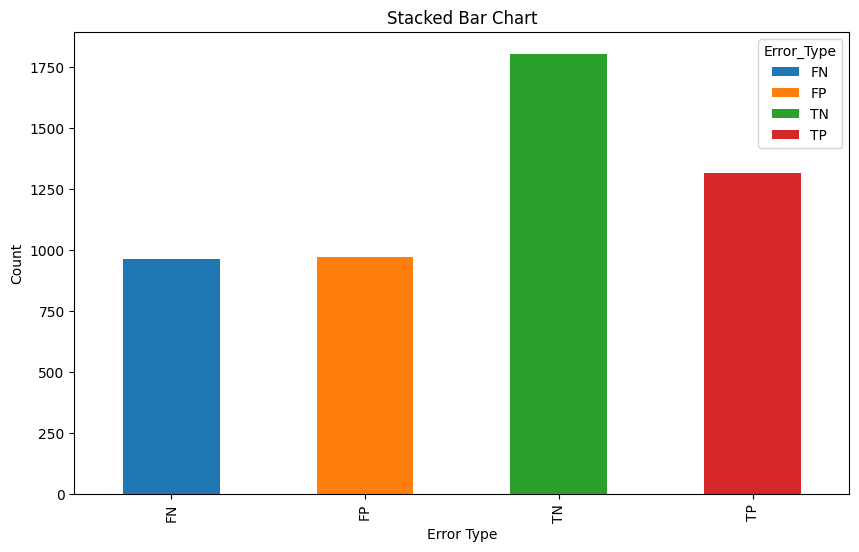

In [12]:
errors_df = entire_dataset[['TP', 'FP', 'FN', 'TN']]

# Melt the DataFrame for easy plotting
melted_df = pd.melt(errors_df, var_name='Error_Type', value_name='Count')

# Pivot the DataFrame for stacked bar chart
pivot_df = melted_df.pivot_table(index='Error_Type', columns='Error_Type', values='Count', aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.title('Stacked Bar Chart')

# Show the plot
plt.show()


# Barchart error labels per demographic group

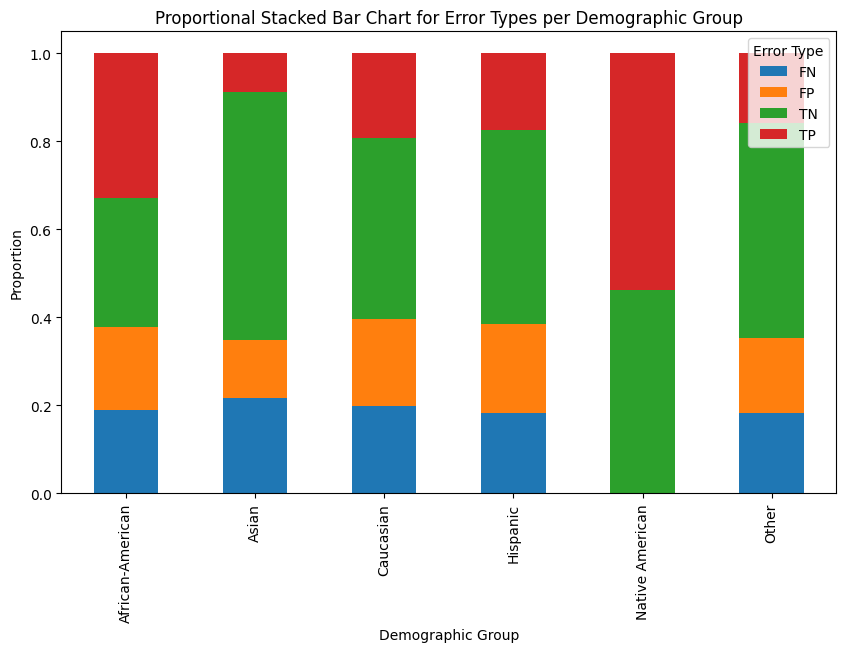

In [13]:
#Group data by 'race' and 'Error_Type' and count occurrences
race_error_counts = entire_dataset.groupby(['race', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
race_error_proportions = race_error_counts.div(race_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
race_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Demographic Group')
plt.xlabel('Demographic Group')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()

# Barchart error labels per gender

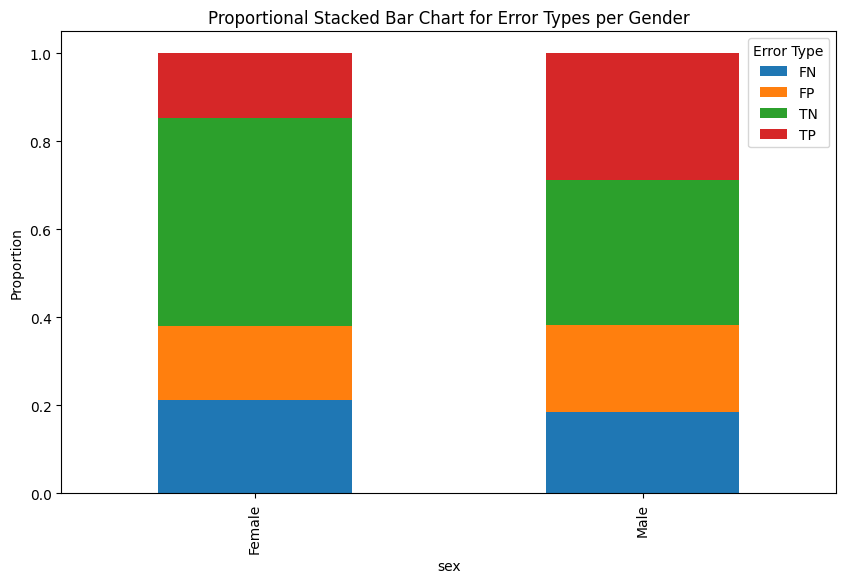

In [14]:
#Group data by 'race' and 'Error_Type' and count occurrences
sex_error_counts = entire_dataset.groupby(['sex', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
sex_error_proportions = sex_error_counts.div(sex_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
sex_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Gender')
plt.xlabel('sex')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()

# Bar Chart Error labels per Age

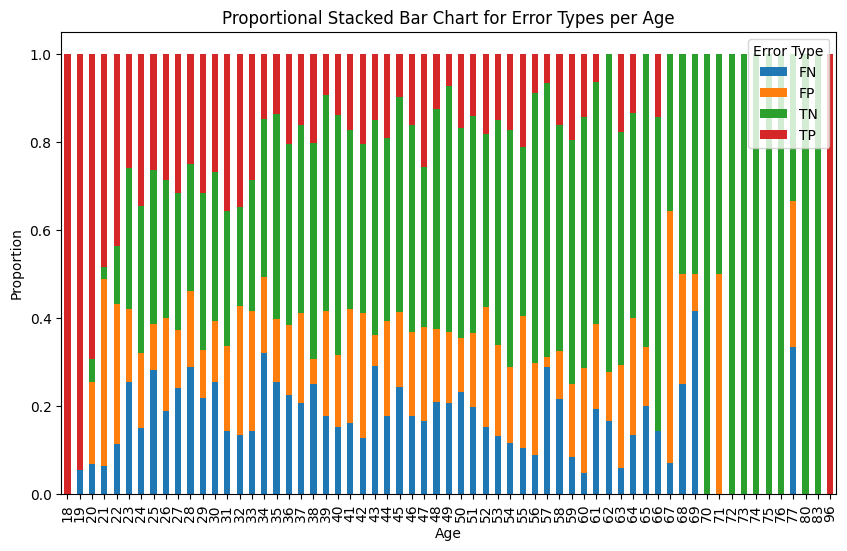

In [15]:
# Group data by 'age' and 'Error_Type' and count occurrences
age_error_counts = entire_dataset.groupby(['age', 'Error_Type']).size().unstack(fill_value=0)

# Normalize counts along the y-axis
age_error_proportions = age_error_counts.div(age_error_counts.sum(axis=1), axis=0)

# Plot the proportional stacked bar chart
age_error_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.title('Proportional Stacked Bar Chart for Error Types per Age')
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.legend(title='Error Type', loc='upper right')

# Show the plot
plt.show()


# Boxplot error label per age with jitter

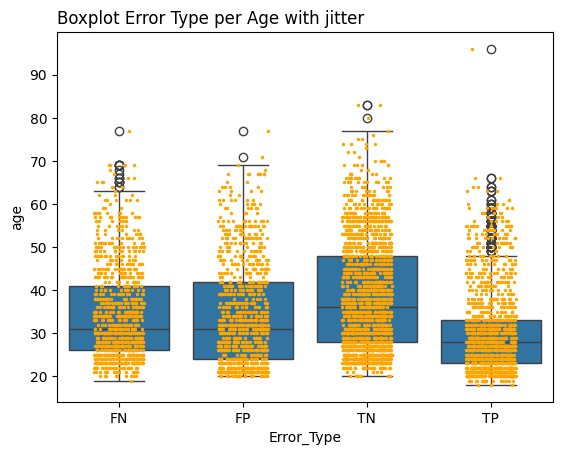

In [16]:
# boxplot
ax = sns.boxplot(x='Error_Type', y='age', data=entire_dataset)
# add stripplot
ax = sns.stripplot(x='Error_Type', y='age', data=entire_dataset, color="orange", jitter=0.2, size=2.5)

# add title
plt.title("Boxplot Error Type per Age with jitter", loc="left")

# show the graph
plt.show()

# Violinplot

Violin plot as combination of boxplot and kernel density plot.

The width represents the densitiy of datapoints at a certian value. Middle bar inside violin represents the interquartile range.


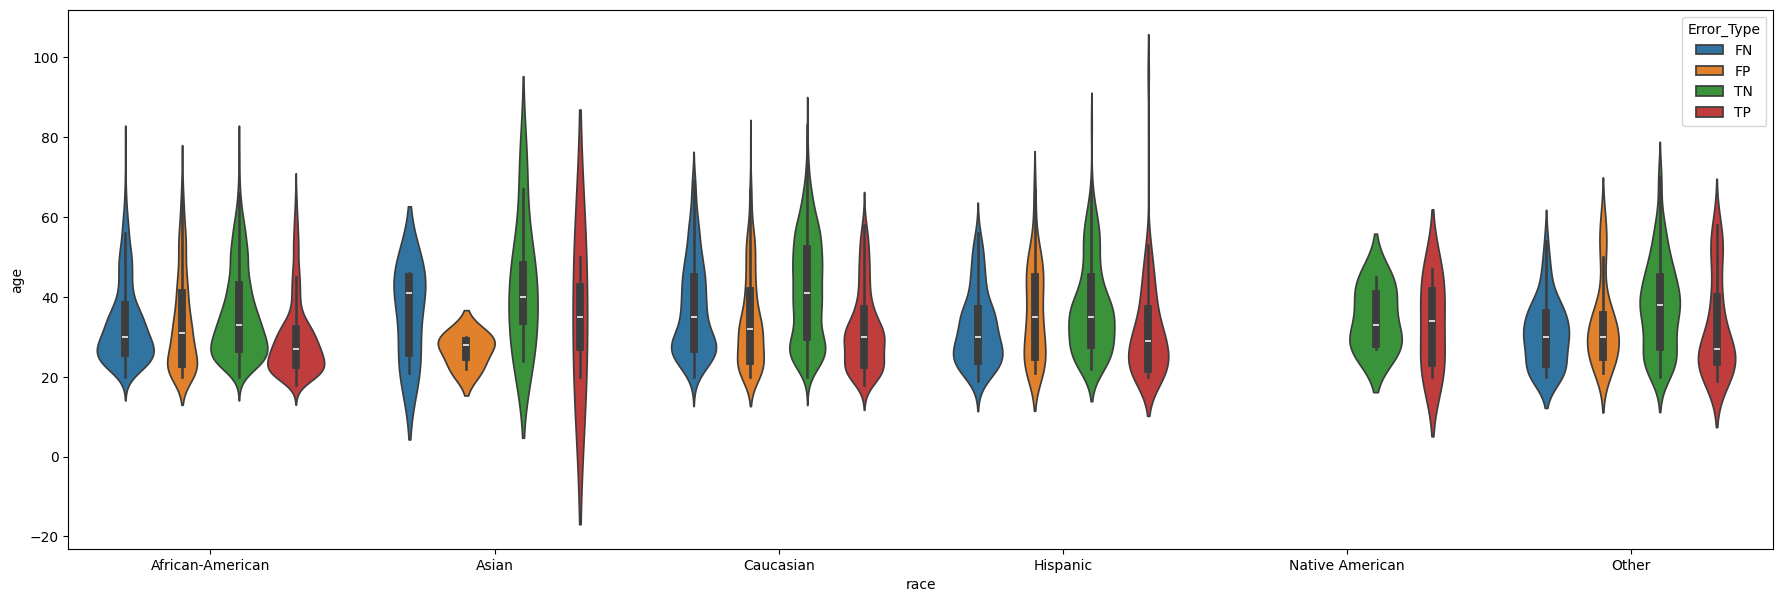

In [17]:
#sns.violinplot(x="Error_Type", y="age", data=entire_dataset)
#plt.show()

#sns.violinplot(x="Error_Type", y="age_cat", data=entire_dataset)
#plt.show()

#plt.figure(figsize=(3, 15))

#sns.violinplot(x="age", y="race", hue = "Error_Type", data=entire_dataset)
#plt.show()

#sns.violinplot(x="Error_Type", y="sex", data=entire_dataset)
#plt.show()

plt.figure(figsize=(22, 7))

sns.violinplot(x="race", y="age", hue = "Error_Type", data=entire_dataset)
plt.show()


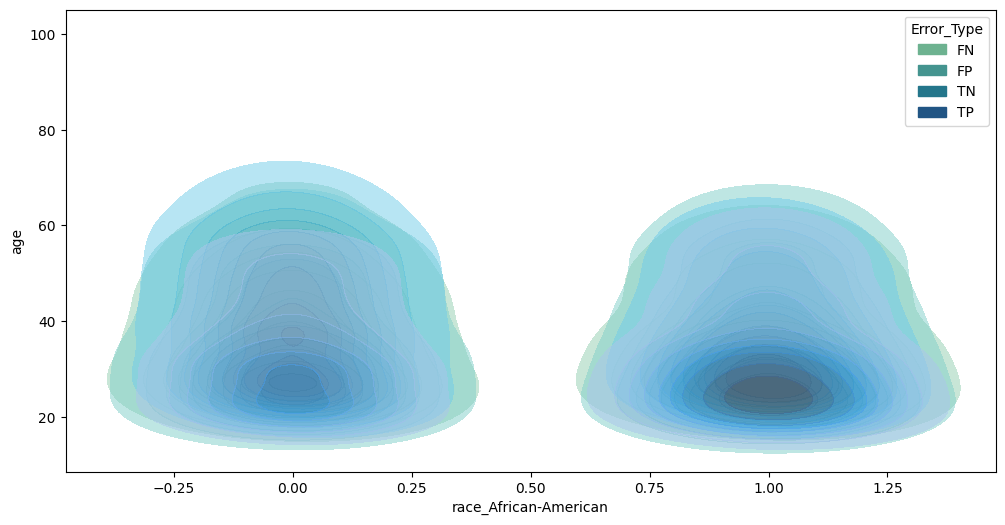

In [18]:
plt.figure(figsize=(12, 6))

sns.kdeplot(data=entire_dataset, x="race_African-American", y="age", hue="Error_Type", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0)

plt.show()


# PCA on all feature values on complete dataset

Explained Variance Ratio: PC1 = 0.21, PC2 = 0.18


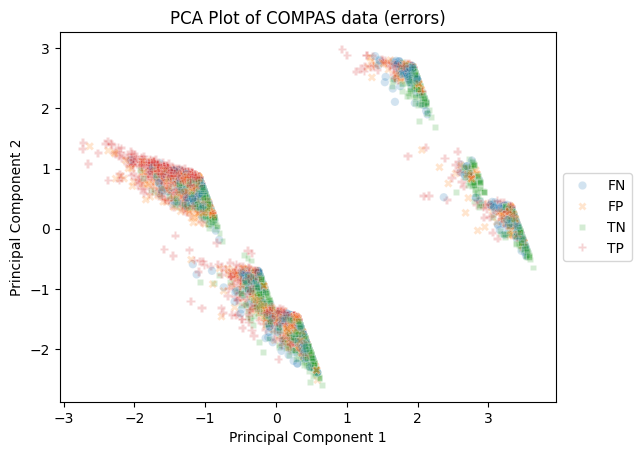

In [19]:
#Each point represents an observation in entire_dataset.
#Points closer together have similar patterns across features. Clusters may indicate subgroups. Outliers deviate from the general pattern

def pca_plot(data, title, alpha):

    #extract features for PCA and drop the other columns in other_features in a dataframe
    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race']]

    # Scale the features before using PCA
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)

    #create a temporary dataset that contains both principal components and other features
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    scatterplot = sns.scatterplot(data=temp_dataset,x ='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="Error_Type", palette="tab10", style="Error_Type")

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

pca_plot(entire_dataset, 'PCA Plot of COMPAS data (errors)', 0.2)

# Scree plot to check for explained variance

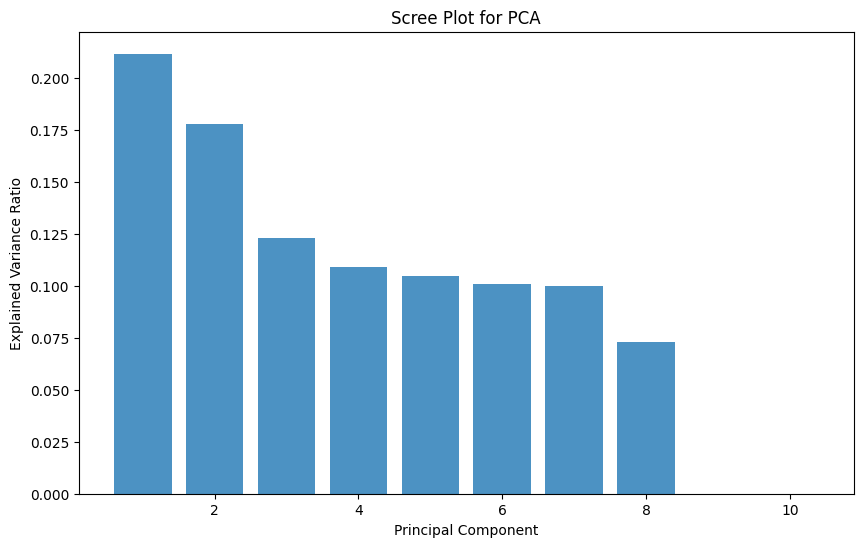

In [20]:
def scree_plot(data, title, alpha):
    # Extract features for PCA and drop the other columns in other_features in a dataframe
    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race'], axis=1)

    # Scale the features before using PCA
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA and get the explained variance ratio for each principal component
    pca = PCA()
    pca_result = pca.fit_transform(scaled_features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Plot scree plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8, align='center')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot for PCA')
    plt.show()

# Example usage
scree_plot(entire_dataset, 'Scree Plot for COMPAS data (errors)', 0.2)


# PCA for TP/FN and TN/FP separately

Explained Variance Ratio: PC1 = 0.21, PC2 = 0.18


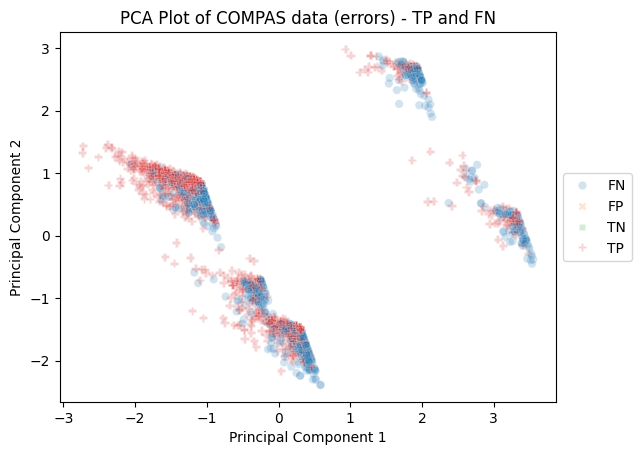

In [21]:
def pca_plot_TPFN(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    # Filter rows where Error_Type is 'TP' or 'FN'
    temp_dataset_filtered = temp_dataset[temp_dataset['Error_Type'].isin(['TP', 'FN'])]

    scatterplot = sns.scatterplot(
        data=temp_dataset_filtered,
        x='Principal Component 1',
        y='Principal Component 2',
        alpha=alpha,
        hue='Error_Type',
        palette='tab10',
        style='Error_Type'
    )

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

# Example usage
pca_plot_TPFN(entire_dataset, 'PCA Plot of COMPAS data (errors) - TP and FN', 0.2)


Explained Variance Ratio: PC1 = 0.21, PC2 = 0.18


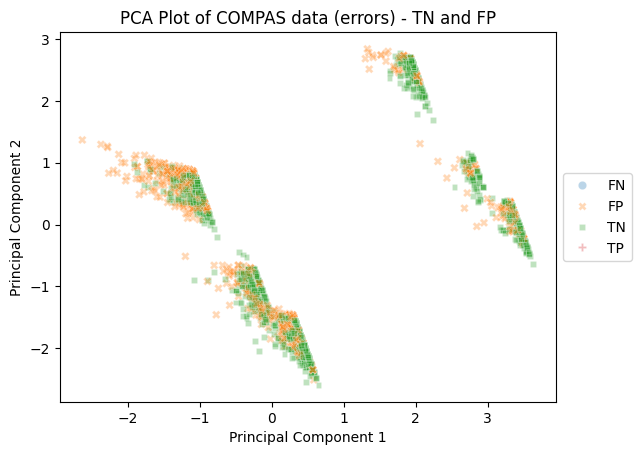

In [22]:
def pca_plot_TNFP(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'sex', 'race']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    # Filter rows where Error_Type is 'TN' or 'FP'
    temp_dataset_filtered = temp_dataset[temp_dataset['Error_Type'].isin(['TN', 'FP'])]

    scatterplot = sns.scatterplot(
        data=temp_dataset_filtered,
        x='Principal Component 1',
        y='Principal Component 2',
        alpha=alpha,
        hue='Error_Type',
        palette='tab10',
        style='Error_Type'
    )

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

# Example usage
pca_plot_TNFP(entire_dataset, 'PCA Plot of COMPAS data (errors) - TN and FP', 0.3)

In [23]:
entire_dataset.drop(columns=['sex', 'race'])
for col in entire_dataset:
  print(col)

age
priors_count
sex_Female
sex_Male
race_African-American
race_Asian
race_Caucasian
race_Hispanic
race_Native American
race_Other
predicted_class
true_class
errors
TP
TN
FN
FP
Error_Type
sex
race


# SHAP

In [24]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 7.9 MB/s eta 0:00:00


Perform SHAP on the testset.

Provide a dataset or masker when creating an Explainer for a tree-based model. While other explainers will not function without data, the tree explainer will default to feature_perturbation='tree_path_dependent', which is not recommended due to its ambiguous interpretation. (Molnar, )

100%|===================| 10071/10100 [04:02<00:00]       

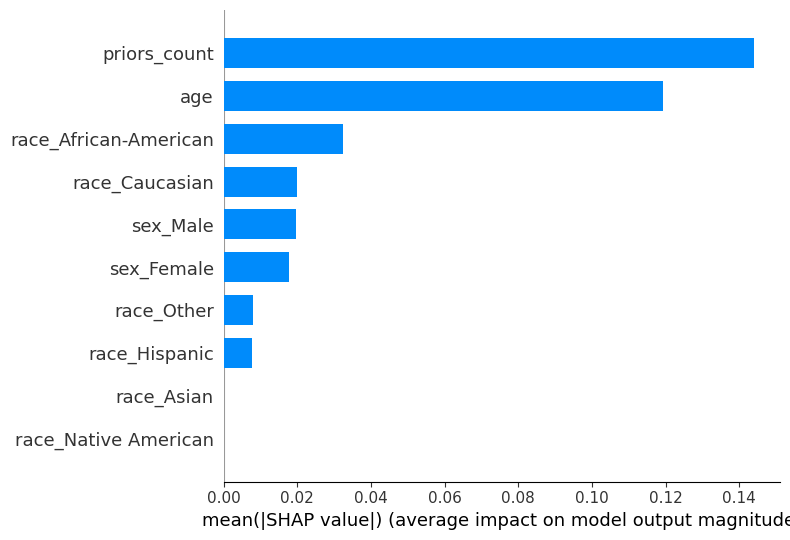

In [25]:
#explainer = shap.TreeExplainer(model, approximate=True)
explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test, plot_type = "bar")

Random forest model includes interactions between the features. However, since there’s only one SHAP value per feature value (and not one for every interaction), we don’t immediately see how features interact. (Molnar)

# Making the final dataset with feature values, error labels and Shap values

We calculate the SHAP values for every instance in the testset (excluding the error labels). The error labels will be added to the data afterwards.

In [26]:
#Creating a copy for storing both original features and Shap values
data_with_shap = X_test.copy()

#loop through each instance i
for index, row in data_with_shap.iterrows():

  #Extract the feature values for current instance
  i_feature_values = row[['age', 'priors_count', 'sex_Female', 'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']]

  #Calculate SHAP values for each instance
  shap_values = explainer.shap_values(i_feature_values)

  #Add new columns with SHAP values to data
  for i, feature in enumerate(['age', 'priors_count', 'sex_Female', 'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']):
    data_with_shap.at[index, f'Shap_{feature}'] = shap_values[0][i]

print(data_with_shap)

      age  priors_count  sex_Female  sex_Male  race_African-American  \
511    26             0           1         0                      1   
5138   30             1           0         1                      0   
7050   52             0           1         0                      0   
3364   38             1           0         1                      1   
3462   44             7           0         1                      1   
...   ...           ...         ...       ...                    ...   
3243   56            10           0         1                      0   
6747   23             1           0         1                      0   
5776   21             2           0         1                      1   
656    47            20           0         1                      1   
3004   37             3           0         1                      0   

      race_Asian  race_Caucasian  race_Hispanic  race_Native American  \
511            0               0              0               

Adding back the remove columns and scale all features to create the final dataset

In [27]:
#scale
scaler = StandardScaler()

scaled_data_with_shap = scaler.fit_transform(data_with_shap)

scaled_data_with_shap = pd.DataFrame(scaled_data_with_shap, columns = data_with_shap.columns)
print(scaled_data_with_shap)

#add back removed columns to create final dataset
Shap_error_data = scaled_data_with_shap.join(entire_dataset[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type']], how = 'left')

Shap_error_data.info()
Shap_error_data.to_csv('/content/Shap_error_data.csv', index=False)

           age  priors_count  sex_Female  sex_Male  race_African-American  \
0    -0.741006     -0.704650    2.041785 -2.041785               0.971110   
1    -0.403563     -0.500527   -0.489768  0.489768              -1.029749   
2     1.452378     -0.704650    2.041785 -2.041785              -1.029749   
3     0.271325     -0.500527   -0.489768  0.489768               0.971110   
4     0.777490      0.724214   -0.489768  0.489768               0.971110   
...        ...           ...         ...       ...                    ...   
5045  1.789822      1.336584   -0.489768  0.489768              -1.029749   
5046 -0.994089     -0.500527   -0.489768  0.489768              -1.029749   
5047 -1.162811     -0.296403   -0.489768  0.489768               0.971110   
5048  1.030573      3.377818   -0.489768  0.489768               0.971110   
5049  0.186964     -0.092280   -0.489768  0.489768              -1.029749   

      race_Asian  race_Caucasian  race_Hispanic  race_Native American  \
0 

In [28]:
#entire_dataset.shape[0]
Shap_error_data.shape[0]

5050

# Create PCA again with SHAP values added

Explained Variance Ratio: PC1 = 0.16, PC2 = 0.11


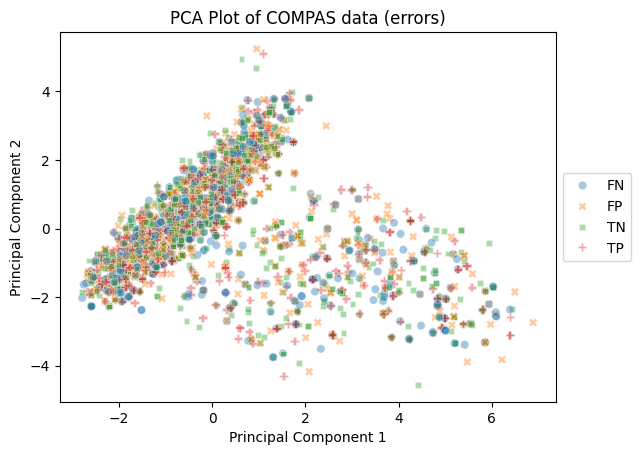

In [29]:
#Create PCA again with shap values

def pca_plot(data, title, alpha):

    #extract features for PCA and drop the other columns in other_features in a dataframe
    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type' ]]

    # Scale the PCA features before using PCA
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)

    #create a temporary dataset that contains both principal components and other features
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    scatterplot = sns.scatterplot(data=temp_dataset,x ='Principal Component 1', y='Principal Component 2', alpha=alpha, hue="Error_Type", palette="tab10", style="Error_Type")

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

pca_plot(Shap_error_data, 'PCA Plot of COMPAS data (errors)', 0.4)

# Scree plot for explained variance

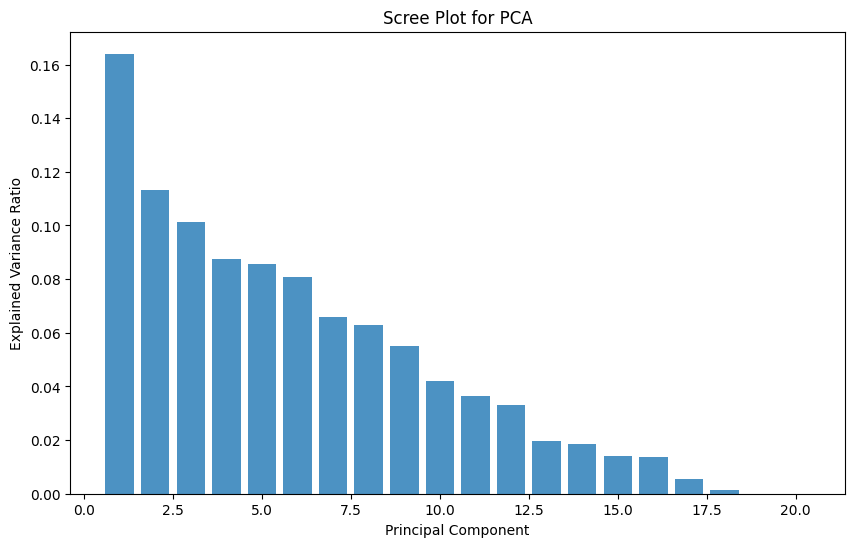

In [30]:
def Scree_plot(data, title, alpha):
    # Extract features for PCA and drop the other columns in other_features in a dataframe
    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type'], axis=1)

    # Scale the features before using PCA
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA and get the explained variance ratio for each principal component
    pca = PCA()
    pca_result = pca.fit_transform(scaled_features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Plot the scree plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8, align='center')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot for PCA')
    plt.show()

Scree_plot(Shap_error_data, 'Scree Plot for COMPAS data (errors)', 0.2)

## 1. PCA Feature labels with SHAP on Testset

In [31]:
#TP/FN with SHAP on testset
def pca_plot_TPFN_SHAP(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    # Filter rows where Error_Type is 'TP' or 'FN'
    temp_dataset_filtered = temp_dataset[temp_dataset['Error_Type'].isin(['TP', 'FN'])]

    scatterplot = sns.scatterplot(
        data=temp_dataset_filtered,
        x='Principal Component 1',
        y='Principal Component 2',
        alpha=alpha,
        hue='Error_Type',
        palette='tab10',
        style='Error_Type'
    )

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

#pca_plot_TPFN_SHAP(Shap_error_data, 'PCA Plot of COMPAS data (errors) - TP and FN', 0.4)


#TN/FP with SHAP on testset
def pca_plot_TNFP_SHAP(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    # Filter rows where Error_Type is 'TN' or 'FP'
    temp_dataset_filtered = temp_dataset[temp_dataset['Error_Type'].isin(['TN', 'FP'])]

    scatterplot = sns.scatterplot(
        data=temp_dataset_filtered,
        x='Principal Component 1',
        y='Principal Component 2',
        alpha=alpha,
        hue='Error_Type',
        palette='tab10',
        style='Error_Type'
    )

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

#pca_plot_TNFP_SHAP(Shap_error_data, 'PCA Plot of COMPAS data (errors) - TN and FP', 0.4)

# SUBPLOT

Explained Variance Ratio: PC1 = 0.16, PC2 = 0.11


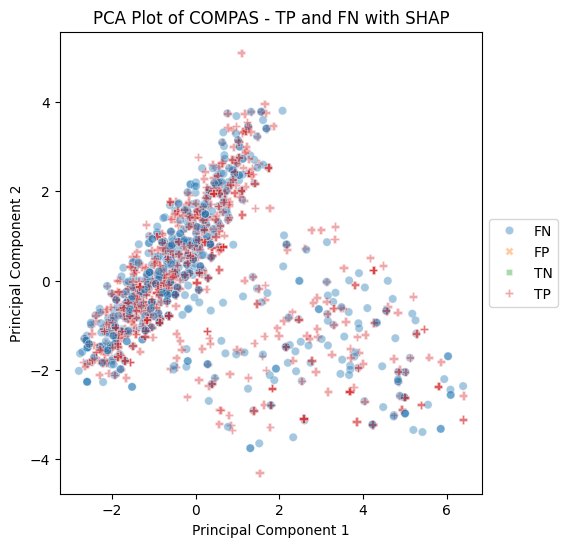

Explained Variance Ratio: PC1 = 0.16, PC2 = 0.11


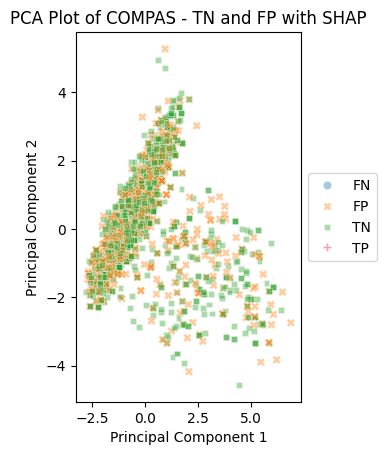

<Figure size 640x480 with 0 Axes>

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Subplot 1
pca_plot_TPFN_SHAP(Shap_error_data, 'PCA Plot of COMPAS - TP and FN with SHAP', 0.4)

plt.subplot(1, 2, 2)  # Subplot 2
pca_plot_TNFP_SHAP(Shap_error_data, 'PCA Plot of COMPAS - TN and FP with SHAP', 0.4)

plt.tight_layout()
plt.show()

# 2. PCA for TP/FN & TN/FP **without** SHAP on TESTSET


In [33]:
#TP/FN without shap on testset

def pca_plot_TPFN_NoSHAP(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'Shap_age', 'Shap_priors_count',
                              'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic',
                              'Shap_race_Native American', 'Shap_race_Other'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'Shap_age', 'Shap_priors_count',
                              'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic',
                              'Shap_race_Native American', 'Shap_race_Other']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    # Filter rows where Error_Type is 'TP' or 'FN'
    temp_dataset_filtered = temp_dataset[temp_dataset['Error_Type'].isin(['TP', 'FN'])]

    scatterplot = sns.scatterplot(
        data=temp_dataset_filtered,
        x='Principal Component 1',
        y='Principal Component 2',
        alpha=alpha,
        hue='Error_Type',
        palette='tab10',
        style='Error_Type'
    )

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

#pca_plot_TPFN_NoSHAP(Shap_error_data, 'PCA Plot of COMPAS data (errors) - TP and FN', 0.4)

#TN/FP without shap on testset
def pca_plot_TNFP_NoSHAP(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'Shap_age', 'Shap_priors_count',
                              'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic',
                              'Shap_race_Native American', 'Shap_race_Other'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'Shap_age', 'Shap_priors_count',
                              'Shap_sex_Female', 'Shap_sex_Male', 'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic',
                              'Shap_race_Native American', 'Shap_race_Other']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    # Filter rows where Error_Type is 'TP' or 'FN'
    temp_dataset_filtered = temp_dataset[temp_dataset['Error_Type'].isin(['TN', 'FP'])]

    scatterplot = sns.scatterplot(
        data=temp_dataset_filtered,
        x='Principal Component 1',
        y='Principal Component 2',
        alpha=alpha,
        hue='Error_Type',
        palette='tab10',
        style='Error_Type'
    )

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

#pca_plot_TNFP_NoSHAP(Shap_error_data, 'PCA Plot of COMPAS data (errors) - TN and FP', 0.4)


# Subplots

Explained Variance Ratio: PC1 = 0.21, PC2 = 0.18


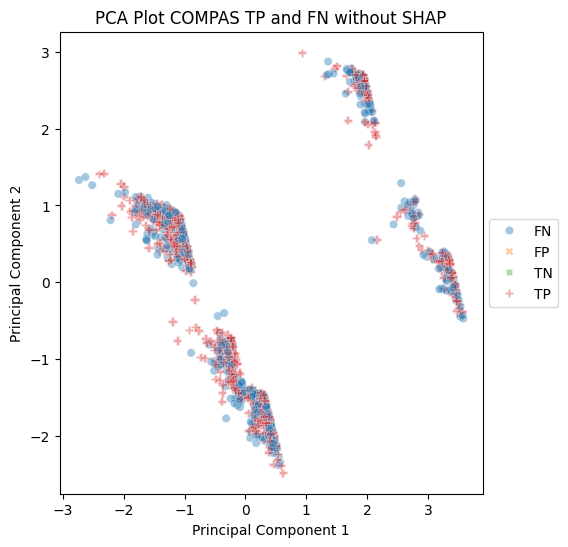

Explained Variance Ratio: PC1 = 0.21, PC2 = 0.18


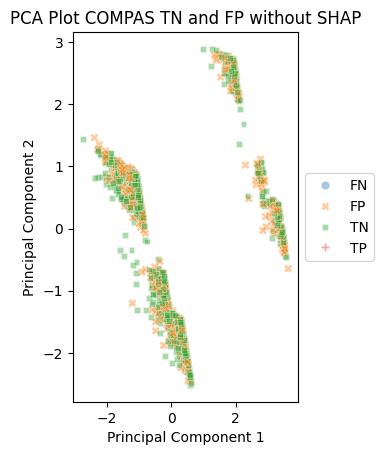

<Figure size 640x480 with 0 Axes>

In [34]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Subplot 1
pca_plot_TPFN_NoSHAP(Shap_error_data, 'PCA Plot COMPAS TP and FN without SHAP', 0.4)

plt.subplot(1, 2, 2)  # Subplot 2
pca_plot_TNFP_NoSHAP(Shap_error_data, 'PCA Plot COMPAS TN and FP without SHAP', 0.4)

plt.tight_layout()
plt.show()

# 3. PCA for TP/FN & TN/FP with only SHAP VALUES on TESTSET

In [35]:
#TP/FN with shap only on testset
def pca_plot_TPFN_shaponly(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'age', 'priors_count', 'sex_Female',
                              'sex_Male', 'race_African-American', 'race_Asian','race_Caucasian','race_Hispanic', 'race_Native American', 'race_Other'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'age', 'priors_count', 'sex_Female',
                              'sex_Male', 'race_African-American', 'race_Asian','race_Caucasian','race_Hispanic', 'race_Native American', 'race_Other']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    # Filter rows where Error_Type is 'TP' or 'FN'
    temp_dataset_filtered = temp_dataset[temp_dataset['Error_Type'].isin(['TP', 'FN'])]

    scatterplot = sns.scatterplot(
        data=temp_dataset_filtered,
        x='Principal Component 1',
        y='Principal Component 2',
        alpha=alpha,
        hue='Error_Type',
        palette='tab10',
        style='Error_Type'
    )

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

#TN/FP with shap only on testset
def pca_plot_TNFP_shaponly(data, title, alpha):

    pca_features = data.drop(['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'age', 'priors_count', 'sex_Female',
                              'sex_Male', 'race_African-American', 'race_Asian','race_Caucasian','race_Hispanic', 'race_Native American', 'race_Other'], axis=1)
    other_features = data[['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'age', 'priors_count', 'sex_Female',
                              'sex_Male', 'race_African-American', 'race_Asian','race_Caucasian','race_Hispanic', 'race_Native American', 'race_Other']]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)

    # Apply PCA with 2 components to the scaled features and create a DataFrame with the resulting principal components
    pca_result = PCA(n_components=2).fit_transform(scaled_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index)
    temp_dataset = pca_df.join(other_features, how='left')
    temp_dataset.rename(columns={0: 'Principal Component 1', 1: 'Principal Component 2'}, inplace=True)

    # Filter rows where Error_Type is 'TP' or 'FN'
    temp_dataset_filtered = temp_dataset[temp_dataset['Error_Type'].isin(['TN', 'FP'])]

    scatterplot = sns.scatterplot(
        data=temp_dataset_filtered,
        x='Principal Component 1',
        y='Principal Component 2',
        alpha=alpha,
        hue='Error_Type',
        palette='tab10',
        style='Error_Type'
    )

    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = PCA(n_components=2).fit(scaled_features).explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

#pca_plot_TPFN_shaponly(Shap_error_data, 'PCA Plot of COMPAS data (errors) - TP and FN', 0.4)
#pca_plot_TPFN_shaponly(Shap_error_data, 'PCA Plot of COMPAS data (errors) - TP and FN', 0.4)

# Subplots

Explained Variance Ratio: PC1 = 0.27, PC2 = 0.15


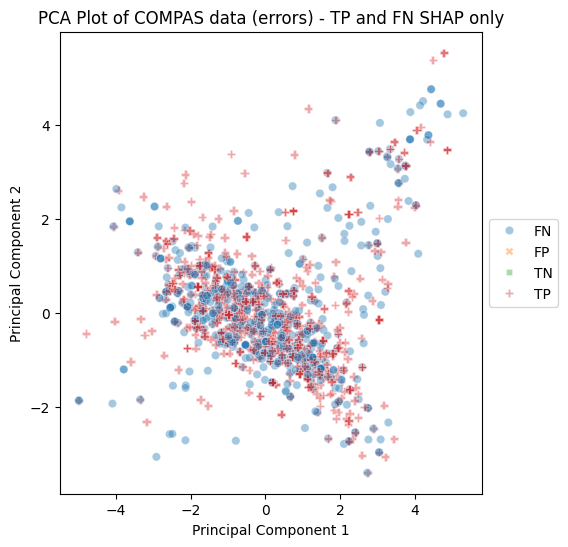

Explained Variance Ratio: PC1 = 0.27, PC2 = 0.15


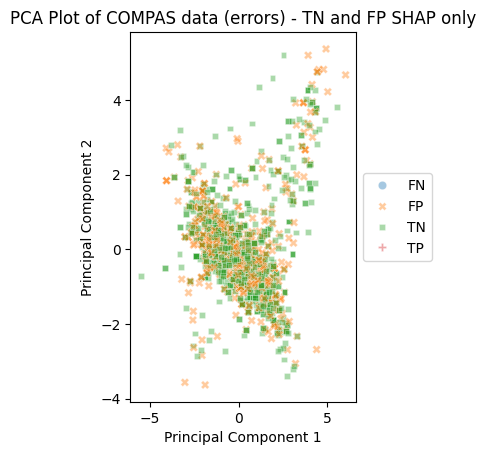

<Figure size 640x480 with 0 Axes>

In [36]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Subplot 1
pca_plot_TPFN_shaponly(Shap_error_data, 'PCA Plot of COMPAS data (errors) - TP and FN SHAP only', 0.4)

plt.subplot(1, 2, 2)  # Subplot 2
pca_plot_TNFP_shaponly(Shap_error_data, 'PCA Plot of COMPAS data (errors) - TN and FP SHAP only', 0.4)

plt.tight_layout()
plt.show()
